# Distribution of Continuous Target Variables

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

conn = sqlite3.connect("../data/rapp.db")

In [2]:
cs_graduates = "sql/graduates.sql"

In [3]:
def load_sql(file, conn=conn):
    with open(file, 'r') as f:
        sql = f.read()
    return pd.read_sql_query(sql, conn)

def group_and_count(df, column_name):
    return df.groupby([column_name]).size().reset_index(name='count')

In [4]:
%matplotlib inline
def group_and_plot(file, column, xlabel=None, ylabel=None, conn=conn):
    df = load_sql(file, conn)
    df = group_and_count(df, column)

    plt.plot(df[column], df["count"])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return df

In [5]:
def hist(file, column, bins, xlabel=None, ylabel=None, conn=conn):
    df = load_sql(file, conn)

    plt.hist(df[column], bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return df


## CS graduation metrics

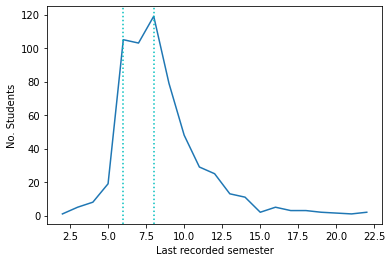

In [6]:
df1 = group_and_plot(cs_graduates, "LastTerm",
                    xlabel="Last recorded semester", ylabel="No. Students")
plt.axvline(x=6, color='c', linestyle=":")
plt.axvline(x=8, color='c', linestyle=":")

Highlighted are the terms 6 (standard duration of study)
and 8 (average needed duration of study).

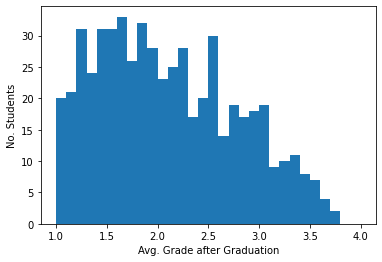

In [7]:
grade_bins = np.linspace(1., 4., num=31, endpoint=True)

df2 = hist(cs_graduates, "Grade", grade_bins,
          xlabel="Avg. Grade after Graduation",
          ylabel="No. Students")


### Map avg. grade vs. terms needed

In [8]:
df = load_sql(cs_graduates)
data = df[["LastTerm", "Grade"]].groupby("LastTerm")

In [9]:
means = data.mean().reset_index()
stds = data.std().reset_index()
stds.head()

,LastTerm,Grade
0,2,NaN
1,3,0.891372
2,4,0.735692
3,5,0.673639
4,6,0.518680


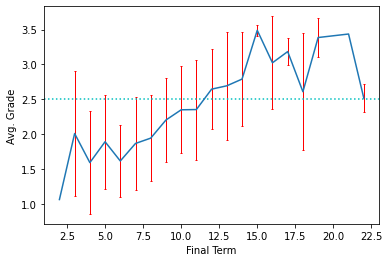

In [10]:
plt.errorbar(means["LastTerm"], means["Grade"], yerr=stds["Grade"],
    ecolor="r", elinewidth=1, capsize=1)
plt.xlabel("Final Term")
plt.ylabel("Avg. Grade")
plt.axhline(y=2.5, color='c', linestyle=':')

Highlighted are the average grade needed for master's admission (2.5)
as well as the standard deviation for each term.

## CS Avg. Student Progress

In [11]:
cs_avg = "sql/avg_progress.sql"

In [12]:
df = load_sql(cs_avg)
df

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr
0,1330409,4,2.666667,8.0,3,4,34.0,Informatik,Bachelor,1,2011
1,1330409,5,1.150000,4.6,4,5,51.0,Informatik,Bachelor,1,2011
2,1330409,6,NaN,NaN,0,0,0.0,Informatik,Bachelor,1,2012
3,1330409,7,NaN,NaN,0,1,10.0,Informatik,Bachelor,1,2012
4,1330409,9,3.500000,7.0,2,1,15.0,Informatik,Bachelor,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
12297,4147124,1,2.766667,16.6,6,7,45.0,Informatik,Bachelor,0,2020
12298,4150575,1,2.150000,4.3,2,3,25.0,Informatik,Bachelor,0,2021
12299,4157400,5,2.837500,22.7,8,14,110.0,Informatik,Bachelor,0,2021
12300,4162892,1,2.400000,9.6,4,6,45.0,Informatik,Bachelor,0,2021


As I was unable to properly create the cumulative sums over average grade and CP, we need to sum the cumulative results per term ourselves.

In [13]:
cum_fields = ["AnzahlNoten", "SummeNoten", "Ects", "AnzahlBE"]

student_data = df.fillna(0).groupby(["Pseudonym"])
cum = student_data[cum_fields].cumsum()
cum_data = df.copy()
cum_data[cum_fields] = cum[cum_fields]
cum_data["AvgNote"] = cum_data["SummeNoten"]/cum_data["AnzahlNoten"]
cum_data

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr
0,1330409,4,2.666667,8.0,3,4,34.0,Informatik,Bachelor,1,2011
1,1330409,5,1.800000,12.6,7,9,85.0,Informatik,Bachelor,1,2011
2,1330409,6,1.800000,12.6,7,9,85.0,Informatik,Bachelor,1,2012
3,1330409,7,1.800000,12.6,7,10,95.0,Informatik,Bachelor,1,2012
4,1330409,9,2.177778,19.6,9,11,110.0,Informatik,Bachelor,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
12297,4147124,1,2.766667,16.6,6,7,45.0,Informatik,Bachelor,0,2020
12298,4150575,1,2.150000,4.3,2,3,25.0,Informatik,Bachelor,0,2021
12299,4157400,5,2.837500,22.7,8,14,110.0,Informatik,Bachelor,0,2021
12300,4162892,1,2.400000,9.6,4,6,45.0,Informatik,Bachelor,0,2021


We further want to model "Bestanden" to mean either Graduate or Dropout.

In [14]:
# Filter out all entries since 2020 (last three terms)
cum_data = cum_data[cum_data["MaxSemesterjahr"] < 2020]
cum_data

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr
0,1330409,4,2.666667,8.0,3,4,34.0,Informatik,Bachelor,1,2011
1,1330409,5,1.800000,12.6,7,9,85.0,Informatik,Bachelor,1,2011
2,1330409,6,1.800000,12.6,7,9,85.0,Informatik,Bachelor,1,2012
3,1330409,7,1.800000,12.6,7,10,95.0,Informatik,Bachelor,1,2012
4,1330409,9,2.177778,19.6,9,11,110.0,Informatik,Bachelor,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
12090,4042357,1,1.925000,7.7,4,3,30.0,Informatik,Bachelor,0,2019
12093,4042393,1,5.000000,5.0,1,0,0.0,Informatik,Bachelor,0,2019
12094,4042635,1,5.000000,5.0,1,0,0.0,Informatik,Bachelor,0,2019
12097,4042843,1,5.000000,10.0,2,0,0.0,Informatik,Bachelor,0,2019


In [15]:
# Average out over all terms
avg_cum = cum_data[cum_fields + ["Fachsemester", "AvgNote", "Bestanden", "MaxSemesterjahr"]]
avg_data = avg_cum.groupby(["Fachsemester", "Bestanden"]).quantile().reset_index()
std_data = avg_cum.groupby(["Fachsemester", "Bestanden"]).std().reset_index()
quant_high = avg_cum.groupby(["Fachsemester", "Bestanden"]).quantile(0.25).reset_index()
quant_low = avg_cum.groupby(["Fachsemester", "Bestanden"]).quantile(0.75).reset_index()

In [16]:
avg_data.head(12)

,Fachsemester,Bestanden,AnzahlNoten,SummeNoten,Ects,AnzahlBE,AvgNote,MaxSemesterjahr
0,1,0,2.0,5.00,10.0,1.0,3.300000,2017.0
1,1,1,1.0,2.70,30.0,3.0,2.000000,2014.0
2,2,0,3.0,8.30,20.0,3.0,3.166667,2017.0
3,2,1,2.0,5.00,50.0,6.0,2.060000,2015.0
4,3,0,4.0,11.60,30.0,4.0,3.236667,2017.0
5,3,1,5.0,9.70,72.0,9.0,2.087500,2015.0
6,4,0,6.0,16.00,50.0,6.0,3.150000,2018.0
7,4,1,8.0,15.30,100.0,12.0,2.145833,2015.0
8,5,0,7.0,19.00,60.0,7.0,3.141667,2017.0
9,5,1,10.0,20.40,125.0,14.0,2.200000,2015.0


In [17]:
def avg_error(avg_data, ycol_name, ylabel, std_data, qhigh=quant_high, qlow=quant_low):
    passed = avg_data["Bestanden"] == 1
    avg_passed = avg_data[passed]
    avg_nb = avg_data[~passed]
    std_passed = std_data[passed]
    std_nb = std_data[~passed]

    terms = avg_passed["Fachsemester"]

    y_passed = avg_passed.fillna(0)[ycol_name]
    err_passed = std_passed.fillna(0)[ycol_name]
    qh_passed = qhigh[passed][ycol_name]
    ql_passed = qlow[passed][ycol_name]
    plt.plot(terms, y_passed,
        # yerr=err_passed,
        # ecolor="r", elinewidth=1, capsize=1,
        label="Graduiert")
    plt.fill_between(terms, ql_passed, qh_passed,
        alpha=0.25, label="25-75 % Quantil")
    # plt.fill_between(terms, y_passed-err_passed, y_passed+err_passed,
    #     color='gray', alpha=0.2)

    terms = avg_nb["Fachsemester"]
    y_nb = avg_nb.fillna(0)[ycol_name]
    err_nb = std_nb.fillna(0)[ycol_name]
    qh_nb = qhigh[~passed][ycol_name]
    ql_nb = qlow[~passed][ycol_name]
    plt.plot(terms, y_nb,
        # yerr=err_nb,
        # ecolor="r", elinewidth=1, capsize=1,
        color='orange',
        label="Dropout")
    plt.fill_between(terms, ql_nb, qh_nb,
        color='orange', alpha=0.25, label="25-75 % Quantil")

    plt.axvline(x=6, linestyle=':', color='c')
    plt.axvline(x=8, linestyle=':', color='c')

    plt.xlabel("Fachsemester")
    plt.ylabel(ylabel)
    plt.legend()

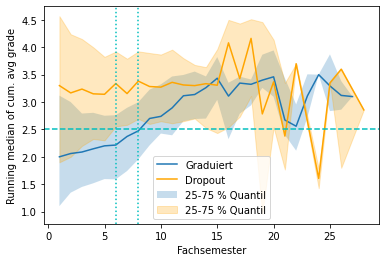

In [18]:
avg_error(avg_data, "AvgNote", "Running median of cum. avg grade", std_data)
plt.axhline(y=2.5, color='c', linestyle='--')

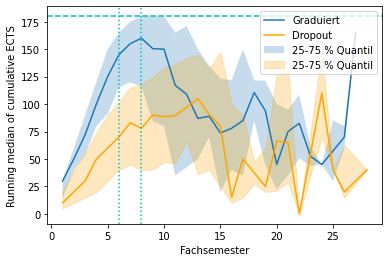

In [19]:
avg_error(avg_data, "Ects", "Running median of cumulative ECTS", std_data)
plt.axhline(y=180, color='c', linestyle='--')

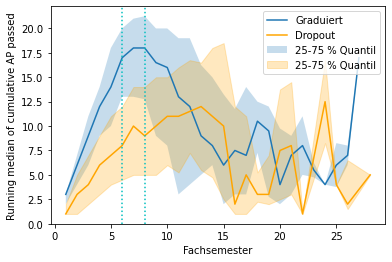

In [20]:
avg_error(avg_data, "AnzahlBE", "Running median of cumulative AP passed", std_data)


### When does Dropout happen?

In [21]:
max_term_data = student_data[["Fachsemester", "Bestanden"]].max().reset_index()
counts = max_term_data.groupby(["Fachsemester", "Bestanden"]).count().reset_index()


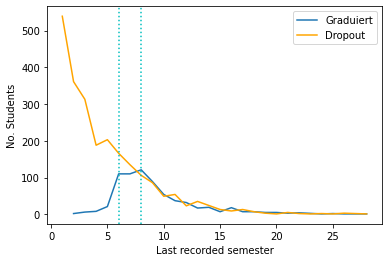

In [22]:
be = counts[counts["Bestanden"] == 1]
nb = counts[counts["Bestanden"] == 0]
plt.plot(be["Fachsemester"], be["Pseudonym"], label="Graduiert")
plt.plot(nb["Fachsemester"], nb["Pseudonym"], label="Dropout", color='orange')

plt.legend()
plt.xlabel("Last recorded semester")
plt.ylabel("No. Students")
plt.axvline(x=6, color='c', linestyle=':')
plt.axvline(x=8, color='c', linestyle=':')

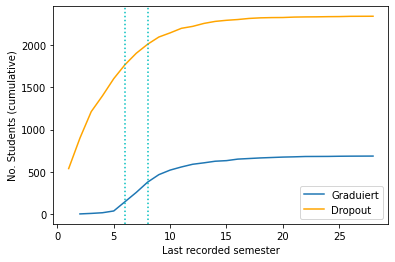

In [23]:
plt.plot(be["Fachsemester"], np.cumsum(be["Pseudonym"]), label="Graduiert")
plt.plot(nb["Fachsemester"], np.cumsum(nb["Pseudonym"]), label="Dropout", color='orange')

plt.legend()
plt.xlabel("Last recorded semester")
plt.ylabel("No. Students (cumulative)")

plt.axvline(x=6, color='c', linestyle=':')
plt.axvline(x=8, color='c', linestyle=':')

### How does dropout relate to ECTS/AP/Grade?

In [24]:
ects_data = cum_data.copy()
ects_data["AvgEcts"] = ects_data["Ects"]/ects_data["Fachsemester"]
ects_data["AvgAP"] = ects_data["AnzahlBE"]/ects_data["Fachsemester"]

# Enforce 3-Dropout definition
ects_data = ects_data[ects_data["MaxSemesterjahr"] < 2020]

ects_data

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr,AvgEcts,AvgAP
0,1330409,4,2.666667,8.0,3,4,34.0,Informatik,Bachelor,1,2011,8.500000,1.000000
1,1330409,5,1.800000,12.6,7,9,85.0,Informatik,Bachelor,1,2011,17.000000,1.800000
2,1330409,6,1.800000,12.6,7,9,85.0,Informatik,Bachelor,1,2012,14.166667,1.500000
3,1330409,7,1.800000,12.6,7,10,95.0,Informatik,Bachelor,1,2012,13.571429,1.428571
4,1330409,9,2.177778,19.6,9,11,110.0,Informatik,Bachelor,1,2013,12.222222,1.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12090,4042357,1,1.925000,7.7,4,3,30.0,Informatik,Bachelor,0,2019,30.000000,3.000000
12093,4042393,1,5.000000,5.0,1,0,0.0,Informatik,Bachelor,0,2019,0.000000,0.000000
12094,4042635,1,5.000000,5.0,1,0,0.0,Informatik,Bachelor,0,2019,0.000000,0.000000
12097,4042843,1,5.000000,10.0,2,0,0.0,Informatik,Bachelor,0,2019,0.000000,0.000000


In [25]:
cum_students = ects_data.groupby(["Pseudonym"])
ects_avg_data = cum_students[["Ects", "AnzahlBE", "Fachsemester", "Bestanden", "MaxSemesterjahr", "AvgNote"]].max()
ects_avg_data["AvgEcts"] = ects_avg_data["Ects"]/ects_avg_data["Fachsemester"]
ects_avg_data["AvgAP"] = ects_avg_data["AnzahlBE"]/ects_avg_data["Fachsemester"]

# Enforce 3-Dropout definition
ects_avg_data = ects_avg_data[ects_avg_data["MaxSemesterjahr"] < 2020]
ects_avg_data = ects_avg_data.reset_index()

ects_avg_data

,Pseudonym,Ects,AnzahlBE,Fachsemester,Bestanden,MaxSemesterjahr,AvgNote,AvgEcts,AvgAP
0,1330409,140.0,13,12,1,2015,2.691667,11.666667,1.083333
1,1551485,100.0,9,3,1,2012,2.370000,33.333333,3.000000
2,1857991,40.0,3,13,1,2010,2.000000,3.076923,0.230769
3,1920027,30.0,4,24,0,2017,1.250000,1.250000,0.166667
4,1968864,180.0,19,7,1,2011,2.403846,25.714286,2.714286
...,...,...,...,...,...,...,...,...,...
2682,4042357,30.0,3,1,0,2019,1.925000,30.000000,3.000000
2683,4042393,0.0,0,1,0,2019,5.000000,0.000000,0.000000
2684,4042635,0.0,0,1,0,2019,5.000000,0.000000,0.000000
2685,4042843,0.0,0,1,0,2019,5.000000,0.000000,0.000000


In [26]:
ects_agg = ects_data.groupby(["Fachsemester", "Bestanden"])

ects_means = ects_agg.quantile().reset_index()
ects_counts = ects_agg.count().reset_index()
ects_std = ects_agg.std().reset_index()
ects_ql = ects_agg.quantile(0.25).reset_index()
ects_qh = ects_agg.quantile(0.75).reset_index()

/tmp/ipykernel_30815/2967222653.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  ects_means = ects_agg.quantile().reset_index()
/tmp/ipykernel_30815/2967222653.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  ects_ql = ects_agg.quantile(0.25).reset_index()
/tmp/ipykernel_30815/2967222653.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  ects_qh = ects_agg.quantile(0.75).reset_index()


In [27]:
ects_means.head()

,Fachsemester,Bestanden,Pseudonym,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,MaxSemesterjahr,AvgEcts,AvgAP
0,1,0,3437232.0,3.300000,5.0,2.0,1.0,10.0,2017.0,10.0,1.000000
1,1,1,3075244.0,2.000000,2.7,1.0,3.0,30.0,2014.0,30.0,3.000000
2,2,0,3409902.0,3.166667,8.3,3.0,3.0,20.0,2017.0,10.0,1.500000
3,2,1,3064533.0,2.060000,5.0,2.0,6.0,50.0,2015.0,25.0,3.000000
4,3,0,3377884.0,3.236667,11.6,4.0,4.0,30.0,2017.0,10.0,1.333333


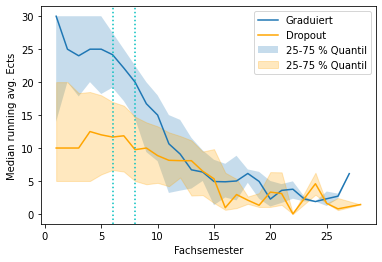

In [28]:
avg_error(ects_means, "AvgEcts", "Median running avg. Ects", ects_std,
    qhigh=ects_qh, qlow=ects_ql)

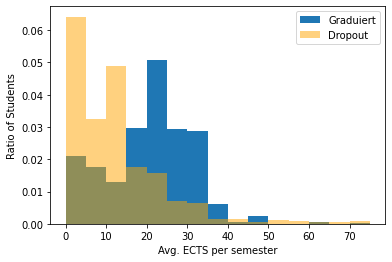

In [29]:
bins = range(0,80, 5)

be = ects_avg_data[ects_avg_data["Bestanden"] == 1]
plt.hist(be["AvgEcts"], bins, label="Graduiert", density=True)

nb = ects_avg_data[ects_avg_data["Bestanden"] == 0]
plt.hist(nb["AvgEcts"], bins, label="Dropout", density=True,
    color='orange', alpha=0.5)

plt.xlabel("Avg. ECTS per semester")
plt.ylabel("Ratio of Students")
plt.legend()

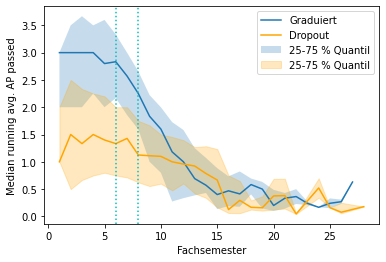

In [30]:
avg_error(ects_means, "AvgAP", "Median running avg. AP passed", ects_std,
    qhigh=ects_qh, qlow=ects_ql)

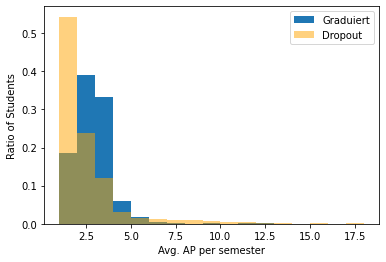

In [31]:
bins = np.linspace(1, 18, 18)

be = ects_avg_data[ects_avg_data["Bestanden"] == 1]
plt.hist(be["AvgAP"], bins, label="Graduiert", density=True)

nb = ects_avg_data[ects_avg_data["Bestanden"] == 0]
plt.hist(nb["AvgAP"], bins, label="Dropout", density=True,
    color='orange', alpha=0.5)

plt.xlabel("Avg. AP per semester")
plt.ylabel("Ratio of Students")
plt.legend()


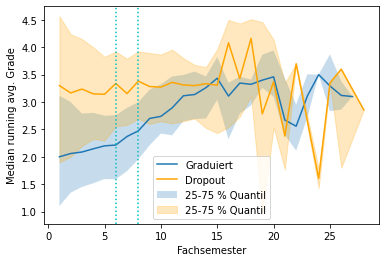

In [32]:
avg_error(ects_means, "AvgNote", "Median running avg. Grade", ects_std,
    qhigh=ects_qh, qlow=ects_ql)


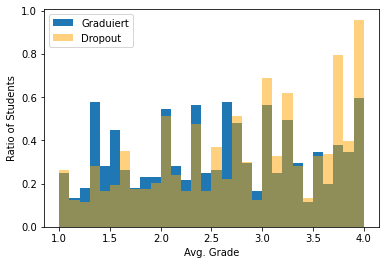

In [33]:
bins = np.linspace(1, 4, 31)

be = ects_avg_data[ects_avg_data["Bestanden"] == 1]
plt.hist(be["AvgNote"], bins, label="Graduiert", density=True)

nb = ects_avg_data[ects_avg_data["Bestanden"] == 0]
plt.hist(nb["AvgNote"], bins, label="Dropout", density=True,
    color='orange', alpha=0.5)

plt.xlabel("Avg. Grade")
plt.ylabel("Ratio of Students")
plt.legend()



## SW Avg. Student Progress

In [34]:
sw_avg = "sql/sw_avg_progress.sql"
df = load_sql(sw_avg)
df

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr
0,2022032,4,1.0,1.0,1,1,6,"Sozialwiss.- Medien, Pol.",Bachelor,0,2012
1,2022032,6,3.1,9.3,3,3,32,"Sozialwiss.- Medien, Pol.",Bachelor,0,2013
2,2022032,7,5.0,5.0,1,0,0,"Sozialwiss.- Medien, Pol.",Bachelor,0,2013
3,2022032,8,5.0,5.0,1,0,0,"Sozialwiss.- Medien, Pol.",Bachelor,0,2014
4,2022032,12,5.0,5.0,1,0,0,"Sozialwiss.- Medien, Pol.",Bachelor,0,2016
...,...,...,...,...,...,...,...,...,...,...,...
9396,4139298,1,2.0,2.0,1,7,13,"Sozialwiss.- Medien, Pol.",Bachelor,0,2020
9397,4139431,1,NaN,NaN,0,1,2,"Sozialwiss.- Medien, Pol.",Bachelor,0,2020
9398,4140951,1,2.3,2.3,1,7,13,"Sozialwiss.- Medien, Pol.",Bachelor,0,2020
9399,4141388,1,3.0,3.0,1,7,13,"Sozialwiss.- Medien, Pol.",Bachelor,0,2020


In [35]:
# Create cumulative sums
student_data = df.fillna(0).groupby(["Pseudonym"])
cum = student_data[cum_fields].cumsum()
cum_data = df.copy()
cum_data[cum_fields] = cum[cum_fields]
cum_data["AvgNote"] = cum_data["SummeNoten"]/cum_data["AnzahlNoten"]

# Filter out all entries since 2020 (last three terms)
cum_data = cum_data[cum_data["MaxSemesterjahr"] < 2020]

cum_data

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr
0,2022032,4,1.000000,1.0,1,1,6,"Sozialwiss.- Medien, Pol.",Bachelor,0,2012
1,2022032,6,2.575000,10.3,4,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2013
2,2022032,7,3.060000,15.3,5,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2013
3,2022032,8,3.383333,20.3,6,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2014
4,2022032,12,3.614286,25.3,7,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2016
...,...,...,...,...,...,...,...,...,...,...,...
9235,4025424,1,5.000000,5.0,1,5,10,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019
9237,4026027,1,3.000000,3.0,1,5,10,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019
9240,4026079,1,4.141176,70.4,17,39,98,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019
9244,4026753,1,2.300000,2.3,1,6,12,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019


In [36]:
# Average out over all terms
avg_cum = cum_data[cum_fields + ["Fachsemester", "AvgNote", "Bestanden", "MaxSemesterjahr"]]
avg_data = avg_cum.groupby(["Fachsemester", "Bestanden"]).quantile().reset_index()
std_data = avg_cum.groupby(["Fachsemester", "Bestanden"]).std().reset_index()
quant_high = avg_cum.groupby(["Fachsemester", "Bestanden"]).quantile(0.25).reset_index()
quant_low = avg_cum.groupby(["Fachsemester", "Bestanden"]).quantile(0.75).reset_index()

avg_data.head(12)

,Fachsemester,Bestanden,AnzahlNoten,SummeNoten,Ects,AnzahlBE,AvgNote,MaxSemesterjahr
0,1,0,1.0,2.70,4.0,1.0,2.700000,2018.0
1,1,1,1.0,2.30,4.0,1.0,2.300000,2013.0
2,2,0,4.0,11.90,32.0,4.0,3.080000,2018.0
3,2,1,4.0,10.25,32.0,4.0,2.400000,2014.0
4,3,0,7.0,20.70,52.0,8.0,3.114286,2018.0
5,3,1,8.0,18.20,62.0,8.0,2.428571,2014.0
6,4,0,9.0,22.90,58.0,8.0,3.000000,2018.0
7,4,1,10.0,22.00,70.0,9.0,2.336364,2015.0
8,5,0,10.0,28.20,70.0,9.0,3.036364,2018.0
9,5,1,12.0,25.70,88.0,11.0,2.242857,2015.0


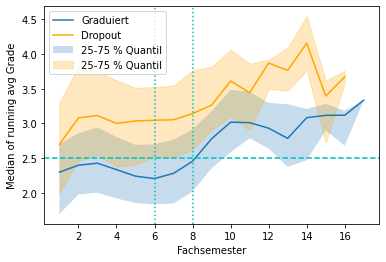

In [37]:
avg_error(avg_data, "AvgNote", "Median of running avg Grade", std_data, qhigh=quant_high, qlow=quant_low)
plt.axhline(y=2.5, color='c', linestyle='--')

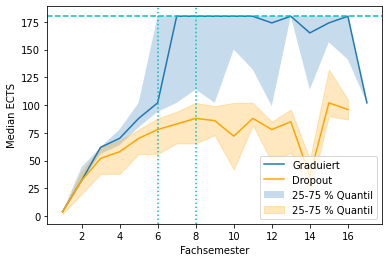

In [38]:
avg_error(avg_data, "Ects", "Median ECTS", std_data, qhigh=quant_high, qlow=quant_low)
plt.axhline(y=180, color='c', linestyle='--')


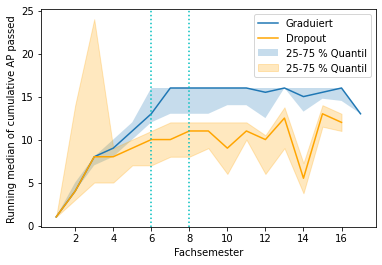

In [39]:
avg_error(avg_data, "AnzahlBE", "Running median of cumulative AP passed", std_data, qhigh=quant_high, qlow=quant_low)


## When does Dropout happen?

In [40]:
max_term_data = student_data[["Fachsemester", "Bestanden"]].max().reset_index()
counts = max_term_data.groupby(["Fachsemester", "Bestanden"]).count().reset_index()

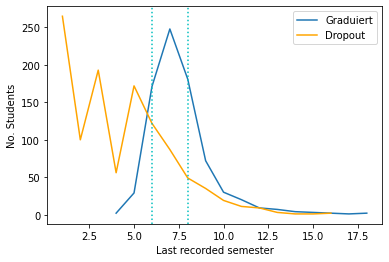

In [41]:
be = counts[counts["Bestanden"] == 1]
nb = counts[counts["Bestanden"] == 0]
plt.plot(be["Fachsemester"], be["Pseudonym"], label="Graduiert")
plt.plot(nb["Fachsemester"], nb["Pseudonym"], label="Dropout", color='orange')

plt.legend()
plt.xlabel("Last recorded semester")
plt.ylabel("No. Students")
plt.axvline(x=6, color='c', linestyle=':')
plt.axvline(x=8, color='c', linestyle=':')

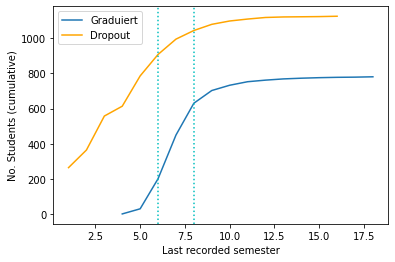

In [42]:
plt.plot(be["Fachsemester"], np.cumsum(be["Pseudonym"]), label="Graduiert")
plt.plot(nb["Fachsemester"], np.cumsum(nb["Pseudonym"]), label="Dropout", color='orange')

plt.legend()
plt.xlabel("Last recorded semester")
plt.ylabel("No. Students (cumulative)")

plt.axvline(x=6, color='c', linestyle=':')
plt.axvline(x=8, color='c', linestyle=':')


### How does dropout relate to ECTS/AP/Grade?

In [43]:
ects_data = cum_data.copy()
ects_data["AvgEcts"] = ects_data["Ects"]/ects_data["Fachsemester"]
ects_data["AvgAP"] = ects_data["AnzahlBE"]/ects_data["Fachsemester"]

# Enforce 3-Dropout definition
ects_data = ects_data[ects_data["MaxSemesterjahr"] < 2020]

ects_data

,Pseudonym,Fachsemester,AvgNote,SummeNoten,AnzahlNoten,AnzahlBE,Ects,Studienfach,Abschluss,Bestanden,MaxSemesterjahr,AvgEcts,AvgAP
0,2022032,4,1.000000,1.0,1,1,6,"Sozialwiss.- Medien, Pol.",Bachelor,0,2012,1.500000,0.250000
1,2022032,6,2.575000,10.3,4,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2013,6.333333,0.666667
2,2022032,7,3.060000,15.3,5,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2013,5.428571,0.571429
3,2022032,8,3.383333,20.3,6,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2014,4.750000,0.500000
4,2022032,12,3.614286,25.3,7,4,38,"Sozialwiss.- Medien, Pol.",Bachelor,0,2016,3.166667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,4025424,1,5.000000,5.0,1,5,10,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019,10.000000,5.000000
9237,4026027,1,3.000000,3.0,1,5,10,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019,10.000000,5.000000
9240,4026079,1,4.141176,70.4,17,39,98,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019,98.000000,39.000000
9244,4026753,1,2.300000,2.3,1,6,12,"Sozialwiss.- Medien, Pol.",Bachelor,0,2019,12.000000,6.000000


In [44]:
cum_students = ects_data.groupby(["Pseudonym"])
ects_avg_data = cum_students[["Ects", "AnzahlBE", "Fachsemester", "Bestanden", "MaxSemesterjahr", "AvgNote"]].max()
ects_avg_data["AvgEcts"] = ects_avg_data["Ects"]/ects_avg_data["Fachsemester"]
ects_avg_data["AvgAP"] = ects_avg_data["AnzahlBE"]/ects_avg_data["Fachsemester"]

# Enforce 3-Dropout definition
ects_avg_data = ects_avg_data[ects_avg_data["MaxSemesterjahr"] < 2020]
ects_avg_data = ects_avg_data.reset_index()

ects_avg_data

,Pseudonym,Ects,AnzahlBE,Fachsemester,Bestanden,MaxSemesterjahr,AvgNote,AvgEcts,AvgAP
0,2022032,38,4,12,0,2016,3.614286,3.166667,0.333333
1,2447924,102,13,6,1,2014,2.300000,17.000000,2.166667
2,2546501,20,3,7,0,2014,4.425000,2.857143,0.428571
3,2615283,84,11,7,0,2019,2.550000,12.000000,1.571429
4,2650739,180,16,9,1,2015,5.000000,20.000000,1.777778
...,...,...,...,...,...,...,...,...,...
1735,4025424,10,5,1,0,2019,5.000000,10.000000,5.000000
1736,4026027,10,5,1,0,2019,3.000000,10.000000,5.000000
1737,4026079,98,39,1,0,2019,4.141176,98.000000,39.000000
1738,4026753,12,6,1,0,2019,2.300000,12.000000,6.000000


In [45]:
ects_agg = ects_data.groupby(["Fachsemester", "Bestanden"])

ects_means = ects_agg.quantile().reset_index()
ects_counts = ects_agg.count().reset_index()
ects_std = ects_agg.std().reset_index()
ects_ql = ects_agg.quantile(0.25).reset_index()
ects_qh = ects_agg.quantile(0.75).reset_index()

/tmp/ipykernel_30815/2967222653.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  ects_means = ects_agg.quantile().reset_index()
/tmp/ipykernel_30815/2967222653.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  ects_ql = ects_agg.quantile(0.25).reset_index()
/tmp/ipykernel_30815/2967222653.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  ects_qh = ects_agg.quantile(0.75).reset_index()


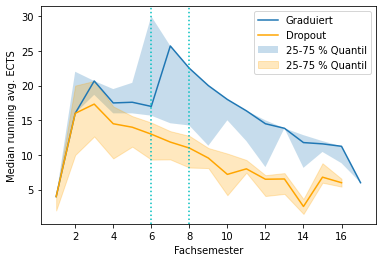

In [46]:
avg_error(ects_means, "AvgEcts", "Median running avg. ECTS", ects_std,
    qhigh=ects_qh, qlow=ects_ql)

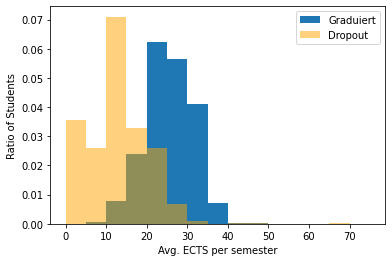

In [47]:
bins = range(0,80, 5)

be = ects_avg_data[ects_avg_data["Bestanden"] == 1]
plt.hist(be["AvgEcts"], bins, label="Graduiert", density=True)

nb = ects_avg_data[ects_avg_data["Bestanden"] == 0]
plt.hist(nb["AvgEcts"], bins, label="Dropout", density=True,
    color='orange', alpha=0.5)

plt.xlabel("Avg. ECTS per semester")
plt.ylabel("Ratio of Students")
plt.legend()

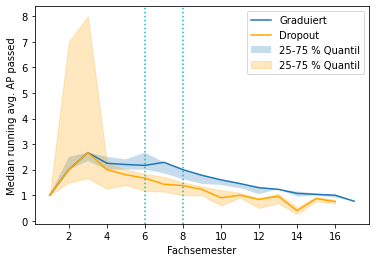

In [48]:
avg_error(ects_means, "AvgAP", "Median running avg. AP passed", ects_std,
    qhigh=ects_qh, qlow=ects_ql)

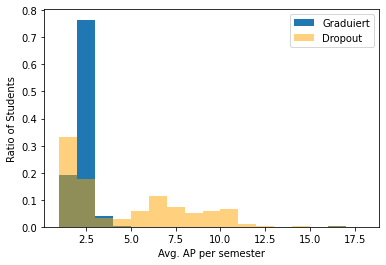

In [49]:
bins = np.linspace(1, 18, 18)

be = ects_avg_data[ects_avg_data["Bestanden"] == 1]
plt.hist(be["AvgAP"], bins, label="Graduiert", density=True)

nb = ects_avg_data[ects_avg_data["Bestanden"] == 0]
plt.hist(nb["AvgAP"], bins, label="Dropout", density=True,
    color='orange', alpha=0.5)

plt.xlabel("Avg. AP per semester")
plt.ylabel("Ratio of Students")
plt.legend()

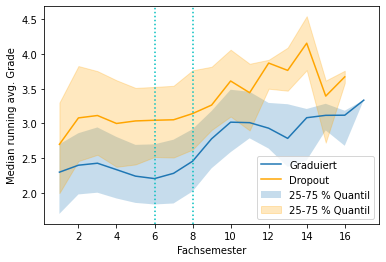

In [50]:
avg_error(ects_means, "AvgNote", "Median running avg. Grade", ects_std,
    qhigh=ects_qh, qlow=ects_ql)

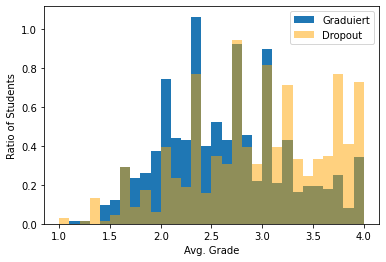

In [51]:
bins = np.linspace(1, 4, 31)

be = ects_avg_data[ects_avg_data["Bestanden"] == 1]
plt.hist(be["AvgNote"], bins, label="Graduiert", density=True)

nb = ects_avg_data[ects_avg_data["Bestanden"] == 0]
plt.hist(nb["AvgNote"], bins, label="Dropout", density=True,
    color='orange', alpha=0.5)

plt.xlabel("Avg. Grade")
plt.ylabel("Ratio of Students")
plt.legend()